<a href="https://colab.research.google.com/github/Hiranmai-T/EVA/blob/master/S6/EVA4_Assignment6_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [0]:
import torch.nn.functional as F
dropout_value = 0.1
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value)
        ) # output_size = 24

        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=8, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 24
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(10),
            nn.Dropout(dropout_value)
        ) # output_size = 10
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 8
        self.pool2 = nn.MaxPool2d(2, 2)
        self.convblock9 = nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False)
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 6
        # self.convblock7 = nn.Sequential(
        #     nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
        #     nn.ReLU(),            
        #     nn.BatchNorm2d(16),
        #     nn.Dropout(dropout_value)
        # ) # output_size = 6
        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) # output_size = 1

        self.convblock8 = nn.Sequential(
            #nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(1, 1), padding=0, bias=False),
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.BatchNorm2d(10),
            # nn.ReLU(),
            # nn.Dropout(dropout_value)
        ) 

        self.dropout = nn.Dropout(dropout_value)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        #x = self.pool2(x)
        #x = self.convblock9(x)
        x = self.convblock6(x)
        #x = self.convblock7(x)
        x = self.gap(x)        
        x = self.convblock8(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [3]:

!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             144
              ReLU-2           [-1, 16, 26, 26]               0
       BatchNorm2d-3           [-1, 16, 26, 26]              32
           Dropout-4           [-1, 16, 26, 26]               0
            Conv2d-5           [-1, 32, 24, 24]           4,608
              ReLU-6           [-1, 32, 24, 24]               0
       BatchNorm2d-7           [-1, 32, 24, 24]              64
           Dropout-8           [-1, 32, 24, 24]               0
            Conv2d-9            [-1, 8, 24, 24]             256
        MaxPool2d-10            [-1, 8, 12, 12]               0
           Conv2d-11           [-1, 10, 10, 10]             720
             ReLU-12           [-1, 10, 10, 10]               0
      BatchNorm2d-13           [-1, 10, 10, 10]              20
          Dropout-14           [-1, 10,

In [0]:
test_loss_l1=[]
test_acc_l1=[]
test_loss_l2=[]
test_acc_l2=[]
test_loss_both=[]
test_acc_both=[]

In [0]:


torch.manual_seed(1)
batch_size = 128

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)


In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []
misclassified=[]
lambda1 = 0.0001
lambda2 = 0.0001
def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    #loss += lambda1*torch.norm(model.parameters(),1)
    #model_params = torch.cat([x.view(-1) for x in model.parameters()])
    #loss += lambda1*torch.norm(model_params,1)
    # regularization_loss = 0
    # for param in model.parameters():
    #   regularization_loss += torch.sum(torch.abs(param))
    # loss += lambda1*regularization_loss
    regularization_loss = 0
    for param in model.parameters():
      regularization_loss += torch.norm(param,2)
    loss += lambda2*regularization_loss
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            temp = pred.eq(target.view_as(pred)).sum().item()
            temp1 = target.view_as(pred)
            if(len(misclassified)<25):
              for i in range(len(temp1)):
                if(temp1[i]!=pred[i]):
                  misclassified.append([data[i],temp1[i],pred[i]])
                if(len(misclassified)==25):
                  break
            correct += temp


    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [7]:
from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=4, gamma=0.1)
#scheduler = MultiStepLR(optimizer, [], gamma=0.1, last_epoch=-1)
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
#                                                      patience=3, 
#                                                      verbose=0, 
#                                                      factor=0.5, 
#                                                      min_lr=0.00001)

EPOCHS = 40
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    # scheduler.step()
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.15229983627796173 Batch_id=468 Accuracy=85.43: 100%|██████████| 469/469 [00:22<00:00, 22.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0975, Accuracy: 9751/10000 (97.51%)

EPOCH: 1


Loss=0.06881549954414368 Batch_id=468 Accuracy=96.94: 100%|██████████| 469/469 [00:22<00:00, 21.65it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0682, Accuracy: 9800/10000 (98.00%)

EPOCH: 2


Loss=0.07661429047584534 Batch_id=468 Accuracy=97.66: 100%|██████████| 469/469 [00:22<00:00, 22.32it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0435, Accuracy: 9877/10000 (98.77%)

EPOCH: 3


Loss=0.047986097633838654 Batch_id=468 Accuracy=98.03: 100%|██████████| 469/469 [00:21<00:00, 22.17it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0340, Accuracy: 9904/10000 (99.04%)

EPOCH: 4


Loss=0.08841418474912643 Batch_id=468 Accuracy=98.20: 100%|██████████| 469/469 [00:22<00:00, 20.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0347, Accuracy: 9897/10000 (98.97%)

EPOCH: 5


Loss=0.09239330887794495 Batch_id=468 Accuracy=98.33: 100%|██████████| 469/469 [00:22<00:00, 21.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0320, Accuracy: 9902/10000 (99.02%)

EPOCH: 6


Loss=0.08463874459266663 Batch_id=468 Accuracy=98.44: 100%|██████████| 469/469 [00:22<00:00, 20.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0297, Accuracy: 9901/10000 (99.01%)

EPOCH: 7


Loss=0.08241976797580719 Batch_id=468 Accuracy=98.52: 100%|██████████| 469/469 [00:22<00:00, 20.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0305, Accuracy: 9911/10000 (99.11%)

EPOCH: 8


Loss=0.06226491183042526 Batch_id=468 Accuracy=98.64: 100%|██████████| 469/469 [00:23<00:00, 19.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0285, Accuracy: 9912/10000 (99.12%)

EPOCH: 9


Loss=0.026624437421560287 Batch_id=468 Accuracy=98.52: 100%|██████████| 469/469 [00:23<00:00, 19.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0268, Accuracy: 9910/10000 (99.10%)

EPOCH: 10


Loss=0.01809711568057537 Batch_id=468 Accuracy=98.69: 100%|██████████| 469/469 [00:23<00:00, 19.61it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0235, Accuracy: 9918/10000 (99.18%)

EPOCH: 11


Loss=0.054067835211753845 Batch_id=468 Accuracy=98.68: 100%|██████████| 469/469 [00:23<00:00, 19.66it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0230, Accuracy: 9919/10000 (99.19%)

EPOCH: 12


Loss=0.04847022891044617 Batch_id=468 Accuracy=98.70: 100%|██████████| 469/469 [00:24<00:00, 19.48it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0276, Accuracy: 9916/10000 (99.16%)

EPOCH: 13


Loss=0.04604996368288994 Batch_id=468 Accuracy=98.77: 100%|██████████| 469/469 [00:24<00:00, 19.35it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0227, Accuracy: 9928/10000 (99.28%)

EPOCH: 14


Loss=0.039811812341213226 Batch_id=468 Accuracy=98.80: 100%|██████████| 469/469 [00:24<00:00, 19.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0242, Accuracy: 9917/10000 (99.17%)

EPOCH: 15


Loss=0.06375829875469208 Batch_id=468 Accuracy=98.79: 100%|██████████| 469/469 [00:23<00:00, 19.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0237, Accuracy: 9926/10000 (99.26%)

EPOCH: 16


Loss=0.010322101414203644 Batch_id=468 Accuracy=98.84: 100%|██████████| 469/469 [00:23<00:00, 20.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0221, Accuracy: 9928/10000 (99.28%)

EPOCH: 17


Loss=0.10165654867887497 Batch_id=468 Accuracy=98.79: 100%|██████████| 469/469 [00:23<00:00, 20.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0235, Accuracy: 9921/10000 (99.21%)

EPOCH: 18


Loss=0.04392491281032562 Batch_id=468 Accuracy=98.91: 100%|██████████| 469/469 [00:23<00:00, 21.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0215, Accuracy: 9924/10000 (99.24%)

EPOCH: 19


Loss=0.056568972766399384 Batch_id=468 Accuracy=98.88: 100%|██████████| 469/469 [00:23<00:00, 20.03it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0221, Accuracy: 9925/10000 (99.25%)

EPOCH: 20


Loss=0.044814858585596085 Batch_id=468 Accuracy=98.93: 100%|██████████| 469/469 [00:23<00:00, 20.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0219, Accuracy: 9925/10000 (99.25%)

EPOCH: 21


Loss=0.0168995950371027 Batch_id=468 Accuracy=98.92: 100%|██████████| 469/469 [00:22<00:00, 20.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0213, Accuracy: 9929/10000 (99.29%)

EPOCH: 22


Loss=0.02366313338279724 Batch_id=468 Accuracy=98.92: 100%|██████████| 469/469 [00:22<00:00, 20.55it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0203, Accuracy: 9928/10000 (99.28%)

EPOCH: 23


Loss=0.05214569717645645 Batch_id=468 Accuracy=98.92: 100%|██████████| 469/469 [00:23<00:00, 20.34it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0198, Accuracy: 9942/10000 (99.42%)

EPOCH: 24


Loss=0.015011128969490528 Batch_id=468 Accuracy=98.99: 100%|██████████| 469/469 [00:22<00:00, 21.35it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0201, Accuracy: 9931/10000 (99.31%)

EPOCH: 25


Loss=0.012854093685746193 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:22<00:00, 22.40it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0212, Accuracy: 9927/10000 (99.27%)

EPOCH: 26


Loss=0.103728286921978 Batch_id=468 Accuracy=98.96: 100%|██████████| 469/469 [00:22<00:00, 20.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0212, Accuracy: 9937/10000 (99.37%)

EPOCH: 27


Loss=0.01179855689406395 Batch_id=468 Accuracy=99.01: 100%|██████████| 469/469 [00:22<00:00, 20.54it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0229, Accuracy: 9926/10000 (99.26%)

EPOCH: 28


Loss=0.01883002743124962 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:22<00:00, 20.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0215, Accuracy: 9933/10000 (99.33%)

EPOCH: 29


Loss=0.013589829206466675 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:22<00:00, 21.05it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0207, Accuracy: 9933/10000 (99.33%)

EPOCH: 30


Loss=0.0121174156665802 Batch_id=468 Accuracy=99.05: 100%|██████████| 469/469 [00:22<00:00, 20.52it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0206, Accuracy: 9931/10000 (99.31%)

EPOCH: 31


Loss=0.013711155392229557 Batch_id=468 Accuracy=99.05: 100%|██████████| 469/469 [00:22<00:00, 21.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0215, Accuracy: 9929/10000 (99.29%)

EPOCH: 32


Loss=0.018204838037490845 Batch_id=468 Accuracy=98.99: 100%|██████████| 469/469 [00:22<00:00, 20.64it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0201, Accuracy: 9929/10000 (99.29%)

EPOCH: 33


Loss=0.01563269831240177 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:22<00:00, 22.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0212, Accuracy: 9934/10000 (99.34%)

EPOCH: 34


Loss=0.18100780248641968 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:21<00:00, 21.71it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0202, Accuracy: 9940/10000 (99.40%)

EPOCH: 35


Loss=0.02050364576280117 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:22<00:00, 20.53it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0198, Accuracy: 9935/10000 (99.35%)

EPOCH: 36


Loss=0.04715963080525398 Batch_id=468 Accuracy=99.09: 100%|██████████| 469/469 [00:22<00:00, 22.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0205, Accuracy: 9937/10000 (99.37%)

EPOCH: 37


Loss=0.09993910789489746 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:22<00:00, 22.65it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0192, Accuracy: 9935/10000 (99.35%)

EPOCH: 38


Loss=0.04214176908135414 Batch_id=468 Accuracy=99.10: 100%|██████████| 469/469 [00:21<00:00, 21.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0199, Accuracy: 9934/10000 (99.34%)

EPOCH: 39


Loss=0.010577911511063576 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:21<00:00, 21.46it/s]



Test set: Average loss: 0.0206, Accuracy: 9931/10000 (99.31%)



Text(0.5, 1.0, 'Test Accuracy')

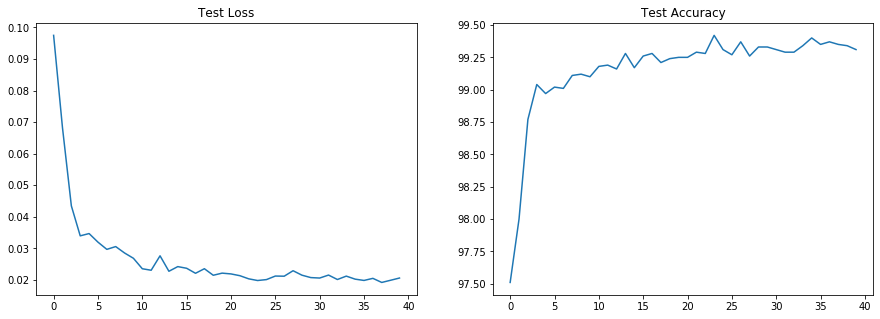

In [8]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1,2,figsize=(15,5))
# axs[0, 0].plot(train_losses)
# axs[0, 0].set_title("Training Loss")
# axs[1, 0].plot(train_acc[4000:])
# axs[1, 0].set_title("Training Accuracy")
axs[0].plot(test_losses)
axs[0].set_title("Test Loss")
axs[1].plot(test_acc)
axs[1].set_title("Test Accuracy")

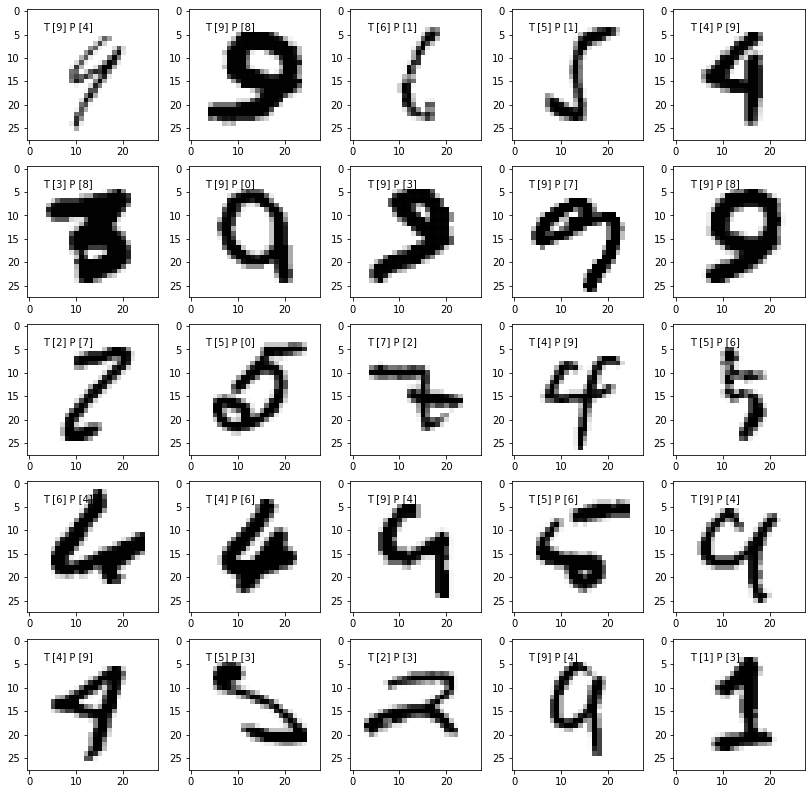

In [9]:
fig, axs = plt.subplots(5,5,figsize=(14,14))
index=0
for i in range(5):
  for j in range(5):
    data,t,p = misclassified[index]
    axs[i,j].imshow(data.cpu().numpy().squeeze(), cmap='gray_r')
    #axs[i,j].set_title(str(t.cpu().numpy())+" "+str(p.cpu().numpy()))
    axs[i,j].annotate("T "+str(t.cpu().numpy())+" P "+str(p.cpu().numpy()),(3,4))
    index+=1;
